In [1]:
import cv2
import sys
import os
import numpy as np
import pandas as pd
from tensorflow.keras.models import Model
from tensorflow.keras.utils import Sequence
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.models import model_from_json
from tensorflow.keras.layers import Input, Dense, LeakyReLU, Concatenate, Lambda, Activation, BatchNormalization, Dropout
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt
%matplotlib inline

C:\Users\Qingyu\Anaconda3\envs\2040project\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
from tensorflow.keras.models import model_from_json
 
#facenet model structure: https://github.com/serengil/tensorflow-101/blob/master/model/facenet_model.json
model = model_from_json(open("facenet_model.json", "r").read())
 
# #pre-trained weights https://drive.google.com/file/d/1971Xk5RwedbudGgTIrGAL4F7Aifu7id1/view?usp=sharing
model.load_weights('facenet_weights.h5')

## Data preprocessing

In [3]:
def get_faces_df(PATH):
    ''' Returns 3 data frames - for train\validation\testing '''
    
    celeb_data = pd.read_csv(PATH + 'identity_CelebA.txt', sep=" ", header=None)
    celeb_data.columns = ["image", "label"]

    # 0 - train, 1 - validation, 2 - test
    train_val_test = pd.read_csv(PATH+'list_eval_partition.csv', usecols=['partition']).values[:, 0]

    df_train = celeb_data.iloc[train_val_test == 0]
    df_valid = celeb_data.iloc[train_val_test == 1]
    df_test = celeb_data.iloc[train_val_test == 2]

    print('Train images:', len(df_train))
    print('Validation images:', len(df_valid))
    print('Test images:', len(df_test))
    
    return df_train, df_valid, df_test, train_val_test

In [4]:
BATCH_SIZE = 2
FACE_DEFAULT_SHAPE = (160, 160)

# Path to celeb dataset
PATH = './data/img_align_celeba/'

df_train, df_valid, df_test, _ = get_faces_df(PATH)

Train images: 162770
Validation images: 19867
Test images: 19962


# Change the architecture

## Add a dense layer with 512 neurons to the model, and LeakyReLU activation with alpha=0.1 before the dense layer with 128 neurons and the l2 normalization layer

### Set the convolutional part to non-trainable

In [5]:
base_model = Model(inputs=model.input, outputs=model.layers[-3].output)

for l in base_model.layers:
    l.trainable = False

base_model.compile(optimizer='adam', loss='cosine_proximity')

In [6]:
def embedder(conv_feat_size):
    '''
    Takes the output of the conv feature extractor and yields the embeddings
    '''
    input = Input((conv_feat_size,), name = 'input')
    normalize = Lambda(lambda x: K.l2_normalize(x, axis=-1), name='normalize')
    x = Dense(512)(input)
    x = LeakyReLU(alpha=0.1)(x)
    x = Dense(128)(x)
    x = normalize(x)
    model = Model(input, x)
    return model
    
def get_siamese_model(base_model):
    
    inp_shape = K.int_shape(base_model.input)[1:]
    conv_feat_size = K.int_shape(base_model.output)[-1]
    
    input_a = Input( inp_shape,  name='anchor')
    input_p = Input( inp_shape,  name='positive')
    input_n = Input( inp_shape,  name='negative')
    emb_model = embedder(conv_feat_size)
    output_a = emb_model(base_model(input_a))
    output_p = emb_model(base_model(input_p))
    output_n = emb_model(base_model(input_n))
    
    merged_vector = Concatenate(axis=-1)([output_a, output_p, output_n])
    model = Model(inputs=[input_a, input_p, input_n],
                  outputs=merged_vector)

    return model

siamese_model = get_siamese_model(base_model)

In [7]:
def triplet_loss(y_true, y_pred, cosine = True, alpha = 0.2):
    embedding_size = K.int_shape(y_pred)[-1] // 3
    ind = int(embedding_size * 2)
    a_pred = y_pred[:, :embedding_size]
    p_pred = y_pred[:, embedding_size:ind]
    n_pred = y_pred[:, ind:]
    if cosine:
        positive_distance = 1 - K.sum((a_pred * p_pred), axis=-1)
        negative_distance = 1 - K.sum((a_pred * n_pred), axis=-1)
    else:
        positive_distance = K.sqrt(K.sum(K.square(a_pred - p_pred), axis=-1))
        negative_distance = K.sqrt(K.sum(K.square(a_pred - n_pred), axis=-1))
    loss = K.maximum(0.0, positive_distance - negative_distance + alpha)
    return loss

In [8]:
# reference to
# https://gist.github.com/tilfin/98bbba47fdc4ac10c4069cce5fabd834

class FaceCropper(object):
    CASCADE_PATH = "./data/haarcascades/haarcascade_frontalface_default.xml"

    def __init__(self):
        self.face_cascade = cv2.CascadeClassifier(self.CASCADE_PATH)

    def generate(self, image_path):
        img = cv2.imread(image_path)
        if (img is None):
            print("Can't open image file")
            return False

        faces = self.face_cascade.detectMultiScale(img, 1.1, 3, minSize=(100, 100))
        if len(faces) == 0:
#             print('Failed to detect face')
            # return resized original image
            return cv2.resize(img, FACE_DEFAULT_SHAPE).astype(float)
        
        max_size = 0
        max_index = 0
        for i, (x, y, w, h) in enumerate(faces):
            if w * h > max_size:
                max_size = w * h
                max_index = i
        (x,y,w,h) = faces[i]
        r = max(w, h) / 2
        centerx = x + w / 2
        centery = y + h / 2
        nx = int(centerx - r)
        ny = int(centery - r)
        nr = int(r * 2)
        
        faceimg = img[ny:ny+nr, nx:nx+nr]
        lastimg = cv2.resize(faceimg, FACE_DEFAULT_SHAPE)
        return lastimg.astype(float)/255.0
        

In [9]:
detecter = FaceCropper()
def load_cropped_face(file):
    img = detecter.generate(PATH + 'img_align_celeba/{}'.format(file))
    return img

In [10]:
class TripletImageLoader(Sequence):
    def __init__(self, df, img_shape, batchSize = 16):
        self.files = df['image'].values
        self.batchSize = batchSize
        self.y = df['label'].values
        self.N = len(self.y)
        self.shape = img_shape
    #gets the number of batches this generator returns
    def __len__(self):
        l,rem = divmod(self.N, self.batchSize)
        return (l + (1 if rem > 0 else 0))
    #shuffles data on epoch end
    def on_epoch_end(self):
        a = np.arange(len(self.y))
        np.random.shuffle(a)
        self.files = self.files[a]
        self.y = self.y[a]
    #gets a batch with index = i
    def __getitem__(self, i):
        start = i*self.batchSize
        stop  = np.min([(i+1)*self.batchSize, self.N]) # clip stop index to be <= N
        # Memory preallocation
        ANCHOR = np.zeros( (stop-start,) + self.shape + (3,) )
        POSITIVE = np.zeros( (stop-start,) + self.shape + (3,) )
        NEGATIVE = np.zeros( (stop-start,) + self.shape + (3,) )
        ancor_labels = self.y[start:stop]
        ancor_images = self.files[start:stop]
        pos_images = []
        neg_images = []
        for k, label in enumerate(ancor_labels):
            pos_idx = np.where(self.y==label)[0]
            neg_idx = np.where(self.y!=label)[0]
            neg_images.append(self.files[np.random.choice(neg_idx)])
            pos_idx_hat = pos_idx[(pos_idx<start) | (pos_idx>stop)]
            if len(pos_idx_hat):
                pos_images.append(self.files[np.random.choice(pos_idx_hat)])
            else:
                # positive examples are within the batch or just 1 example in dataset
                pos_images.append(self.files[np.random.choice(pos_idx)])
                
        for k, (a, p, n) in enumerate(zip(ancor_images, pos_images, neg_images)):
            ANCHOR[k] = load_cropped_face(a)
            POSITIVE[k] = load_cropped_face(p)
            NEGATIVE[k] = load_cropped_face(n)
            
        return [ANCHOR, POSITIVE, NEGATIVE], np.empty(k+1) # we don't need labels so we reutrn dummy label (Keras requierments)

### Training

In [11]:
train_gen = TripletImageLoader(df_train, FACE_DEFAULT_SHAPE, batchSize = BATCH_SIZE)
valid_gen = TripletImageLoader(df_valid, FACE_DEFAULT_SHAPE, batchSize = BATCH_SIZE)
siamese_model.compile(Adam(lr = 0.0001), loss = triplet_loss)

checkpoint = ModelCheckpoint('Model1.h5', monitor='val_loss', 
                             verbose=1, save_best_only=True, save_weights_only=False)

# Change workers>1 and use_multiprocessing=True if you're working on Linux
history = siamese_model.fit_generator(train_gen, steps_per_epoch=len(train_gen), 
                    epochs=5, validation_data=valid_gen, validation_steps=len(valid_gen),
                    workers=1, use_multiprocessing=False, callbacks=[checkpoint])


Epoch 1/5
81384/81385 [============================>.] - ETA: 0s - loss: 0.0310
Epoch 00001: val_loss improved from inf to 0.02991, saving model to Model1.h5
81385/81385 [==============================] - 5299s 65ms/step - loss: 0.0310 - val_loss: 0.0299
Epoch 2/5
81384/81385 [============================>.] - ETA: 0s - loss: 0.0253
Epoch 00002: val_loss did not improve from 0.02991
81385/81385 [==============================] - 4880s 60ms/step - loss: 0.0253 - val_loss: 0.0308
Epoch 3/5
81384/81385 [============================>.] - ETA: 0s - loss: 0.0237
Epoch 00003: val_loss did not improve from 0.02991
81385/81385 [==============================] - 4881s 60ms/step - loss: 0.0237 - val_loss: 0.0317
Epoch 4/5
81384/81385 [============================>.] - ETA: 0s - loss: 0.0229
Epoch 00004: val_loss improved from 0.02991 to 0.02902, saving model to Model1.h5
81385/81385 [==============================] - 4880s 60ms/step - loss: 0.0229 - val_loss: 0.0290
Epoch 5/5
81384/81385 [=======

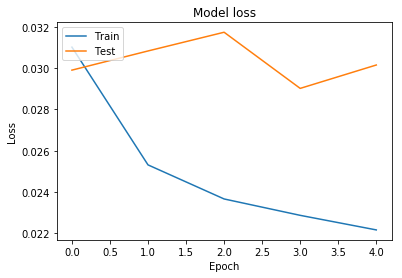

In [12]:
# # Plot training & validation accuracy values
# plt.plot(history.history['acc'])
# plt.plot(history.history['val_acc'])
# plt.title('Model accuracy')
# plt.ylabel('Accuracy')
# plt.xlabel('Epoch')
# plt.legend(['Train', 'Test'], loc='upper left')
# plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [13]:
siamese_model_json = siamese_model.to_json()
with open("Model1.json", "w") as json_file:
    json_file.write(siamese_model_json)

In [14]:
siamese_model.save('Model1.h5')